In [90]:
# import stuff 
import pandas as pd
from ftplib import FTP
import os
import numpy as np
import sklearn 
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# read in supplementary table
drugInfo = pd.read_csv("Drug_Info_Supp_Table.csv")
drugInfo["Drug"] = drugInfo["Drug"].str.strip()

# group all drugs by their type and turn into dictionary
drugTypes = drugInfo.groupby("Type")["Drug"].apply(list).to_dict()

# get ordered list of drugs arranged by drug type
orderedDrugsList = []
type_boundaries = []
for type, drugs in drugTypes.items():
    for drug in drugs:
        orderedDrugsList.append(drug)
    type_boundaries.append(len(orderedDrugsList))


In [76]:
# make a table with all mean intensity values for all of the drugs
allDrugs = drugInfo["Drug"].to_list()
combined = pd.DataFrame(columns=["gene"])

# set up FTP 
ftp = FTP("massive-ftp.ucsd.edu")
ftp.login()
ftp.cwd("/v06/MSV000093659/other/Dose response data - Jurkat proteome")

for drug in allDrugs:
    # make a string with the drug name + _ALL.txt 
    drugFileName = f"{drug}_ALL.txt"

    # check if the file already exists locally (already downloaded it)
    if not os.path.exists(drugFileName):

        # if it doesn't already exist, use FTP to get that file from the server
        drugPath = f"{drug}/TXTs_Classified"
        ftp.cwd(drugPath)
        
        # download/write the file in binary mode
        with open(drugFileName, "wb") as file:
        # download the file "RETR fileName"
            ftp.retrbinary(f"RETR {drugFileName}", file.write)
        
        # move back to the Jurkat proteome directory
        ftp.cwd("../../")

    # load the file as a dataframe
    drugData = pd.read_csv(drugFileName, delimiter = "\t") 

    # select the gene and mean intensity columns  
    meanData = drugData[["gene", "Mean_Intensity"]]
    # rename mean intensity column to include the name of the drug
    renamedData = meanData.rename(columns = {"Mean_Intensity":f"{drug}"})
    # add both of those columns to a combined dataframe (Created before the for loop)
    combined = pd.merge(combined, renamedData, how = "outer", on = "gene")

ftp.quit()
combined.set_index("gene")
combined.head()
combined.to_csv("Mean_Intensity_Matrix_All_Drugs.csv", index = False)


In [ ]:
# create cosine similarity matrix for mean intensity

# load matrix and fill in empty vals with 0 
meanIntensityMatrix = pd.read_csv("Mean_Intensity_Matrix_All_Drugs.csv", index_col = 0).fillna(0)
# make column names just the drug name (remove _Mean_Intensity suffix!)
meanIntensityMatrix.columns = meanIntensityMatrix.columns.str.removesuffix("_Mean_Intensity")

# transpose data so drugs become rows instead of columns
transposedData = meanIntensityMatrix.transpose()
# save drug names index column for after
drugNames = transposedData.index

# plug transposed data into cosine_similarity function
cosineSimilarityMatrix = cosine_similarity(transposedData)
# convert to a dataframe and make row and column labels be the drug names
cosineSimilarityMatrix = pd.DataFrame(cosineSimilarityMatrix, columns = drugNames, index = drugNames)
cosineSimilarityMatrix.to_csv("Cosine_Similarity_Matrix.csv")

reorderedCosMatrix = cosineSimilarityMatrix.loc[orderedDrugsList, orderedDrugsList]



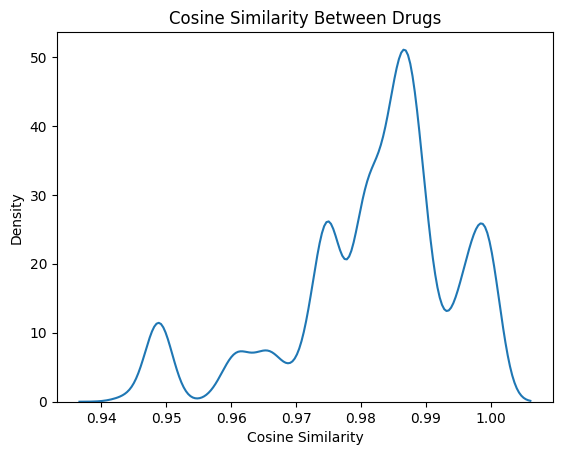

In [74]:
# plot overall cosine distribution for mean intensity 

cosineArray = cosineSimilarityMatrix.to_numpy()
# get the indices of the lower triangle in the array
bottomDiagIndices = numpy.tril_indices_from(cosineArray, k = -1)
# use indices to get values of the lower triangle in the array
bottomDiagVals = cosineArray[bottomDiagIndices]

# plot the distribution
sns.kdeplot(bottomDiagVals)
plt.xlabel("Cosine Similarity")
plt.title("Cosine Similarity Between Drugs")
plt.show()


In [ ]:
# plot distributions for each drug subtype 
for type, drugNames in drugTypes.items():
    print(f"Type: {type}\nDrugs:\n\t{drugNames}")

    # get the sub-matrix of drugs for this type 
    subTypeMatrix = cosineSimilarityMatrix.loc[drugNames, drugNames]
    # convert submatrix to a numpy array
    subArray = subTypeMatrix.to_numpy()
    # get indices of the lower triangle
    subBottomIndices = numpy.tril_indices_from(subArray, k = -1)
    # use indices to get values of the lower triangle
    subBottomVals = subArray[subBottomIndices]

    # plot the distribution
    sns.kdeplot(subBottomVals)
    plt.xlabel("Cosine Similarity")
    plt.title(f"Cosine Similarity Between {type}s")
    plt.show()
    

In [ ]:
# compare within-group vs between-group similarities

# make one list of all the similarity values for pairs where both drugs are within the same group
withinGroupPairs = []
# make another list of all the similarity values for pairs where the two drugs are in different groups
btwGroupPairs = []
# make new dict with drugs as keys and types as values 
drugsToTypesDict = {}
for type, drugs in drugTypes.items():
    for drug in drugs:
        drugsToTypesDict[drug] = type

# nested for loop
# go through the list of drugs (orderedDrugsList)
for index, drug1 in enumerate(orderedDrugsList):
    # save curr drug (row) type in a var
    drug1Type = drugsToTypesDict[f"{drug1}"]
    # go through the list of drugs again but always starting at i (out loop drug) + 1 
    for drug2Index in range(index+1, len(orderedDrugsList)):
        drug2 = orderedDrugsList[drug2Index]
        # save curr drug (col) type in a var
        drug2Type = drugsToTypesDict[f"{drug2}"]
        # save curr similarity value in a var
        similarity = cosineSimilarityMatrix.loc[drug1, drug2]
        # if drug 1 type (row) and drug 2 type (col) are the same
        if drug1Type == drug2Type:
            # add value of that pair's comparison (curr loc in the similarity matrix) to withinGroupPairs
            withinGroupPairs.append(similarity)
        else:
            # add value of that pair's comparison (curr loc in the similarity matrix) to btwGroupPairs
            btwGroupPairs.append(similarity)

# plot the distributions of within-group similarities and between-group similarities and compare them
sns.kdeplot(withinGroupPairs, label = "within group")
sns.kdeplot(btwGroupPairs, label = "between groups")
plt.xlabel("Cosine Similarity")
plt.title("Cosine Similarity Distributions")
plt.legend()
plt.show()


# example

# drugs: A B C D E 

# outer loop, drug1 = A, drug1 = B, drug1 = C, drug1 = D, drug1 = E
    # inner loop, drug2 = B, C, D, E. drug2 = C, D, E. drug2 = D, E. drug2 = E. drug2 = done
        # iteration 1 pairs: AB, AC, AD, AE
        # iteration 2 pairs: BC, BD, BE
        # iteration 3 pairs: CD, CE
        # iteration 4 pairs: DE
        # iteration 5 pairs: done




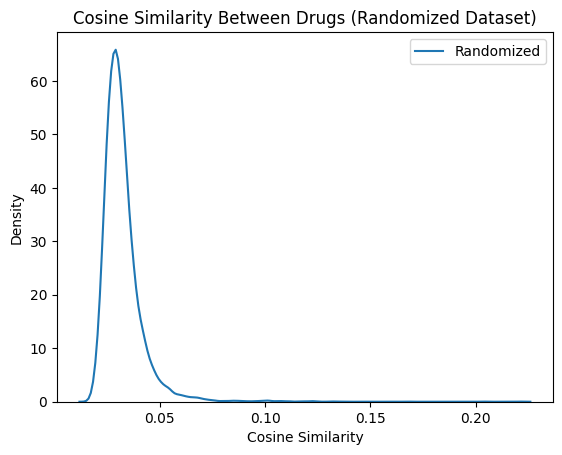

In [ ]:
# plot randomized distribution




# randomize the dataset (shuffle gene values, so gene 1 might actually be the value for gene 12, etc.)
    # go through each col and shuffle around the rows just for that col, repeat for all cols (drugs)
randomColumns = {}

for drugName, drugValues in meanIntensityMatrix.items():
    valArray = drugValues.to_numpy()
    randomValArray = np.random.permutation(valArray)
    randomColumns[drugName] = randomValArray

randomMeanIntensityMatrix = pd.DataFrame(randomColumns)

# transpose data so drugs are rows, genes are columns
randomTransposedMatrix = randomMeanIntensityMatrix.transpose()

# save drug names index column for after
drugNames = transposedData.index

# make new (randomized) cosine similarity matrix from the shuffled data
randomCosineSimilarityMatrix = cosine_similarity(randomTransposedMatrix)
# convert to a dataframe and make row and column labels the drug names
randomCosineSimilarityMatrix = pd.DataFrame(randomCosineSimilarityMatrix, columns = drugNames, index = drugNames)
# create randomized csv
randomCosineSimilarityMatrix.to_csv("Cosine_Similarity_Matrix.csv")
# reorder similarity matrix according to drug type
reorderedRandomCosMatrix = randomCosineSimilarityMatrix.loc[orderedDrugsList, orderedDrugsList]

# plot the real and randomized distributions together and compare
randomCosineArray = reorderedRandomCosMatrix.to_numpy()
# get the indices of the lower triangle in the array
randomBottomDiagIndices = numpy.tril_indices_from(randomCosineArray, k = -1)
# use indices to get values of the lower triangle in the array
randomBottomDiagVals = randomCosineArray[randomBottomDiagIndices]

# plot the distribution
sns.kdeplot(randomBottomDiagVals, label = "Randomized")
plt.xlabel("Cosine Similarity")
plt.title("Cosine Similarity Between Drugs (Randomized Dataset)")
plt.legend()
plt.show()

# maybe compute/compare  other statistics like mean or median similarity values (?)


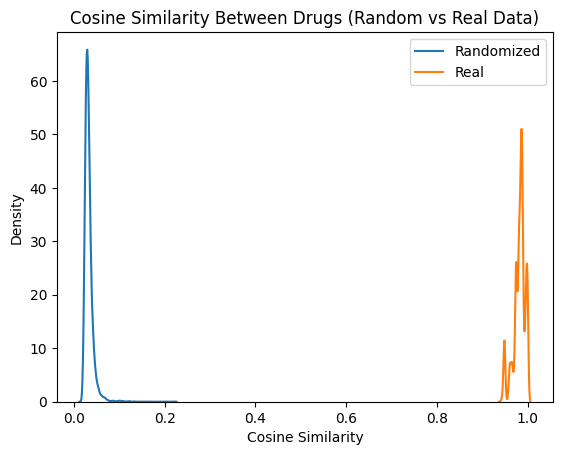

In [84]:
# compare randomized vs real distributions
sns.kdeplot(randomBottomDiagVals, label = "Randomized")
sns.kdeplot(bottomDiagVals, label = "Real")
plt.xlabel("Cosine Similarity")
plt.title("Cosine Similarity Between Drugs (Random vs Real Data)")
plt.legend()
plt.show()

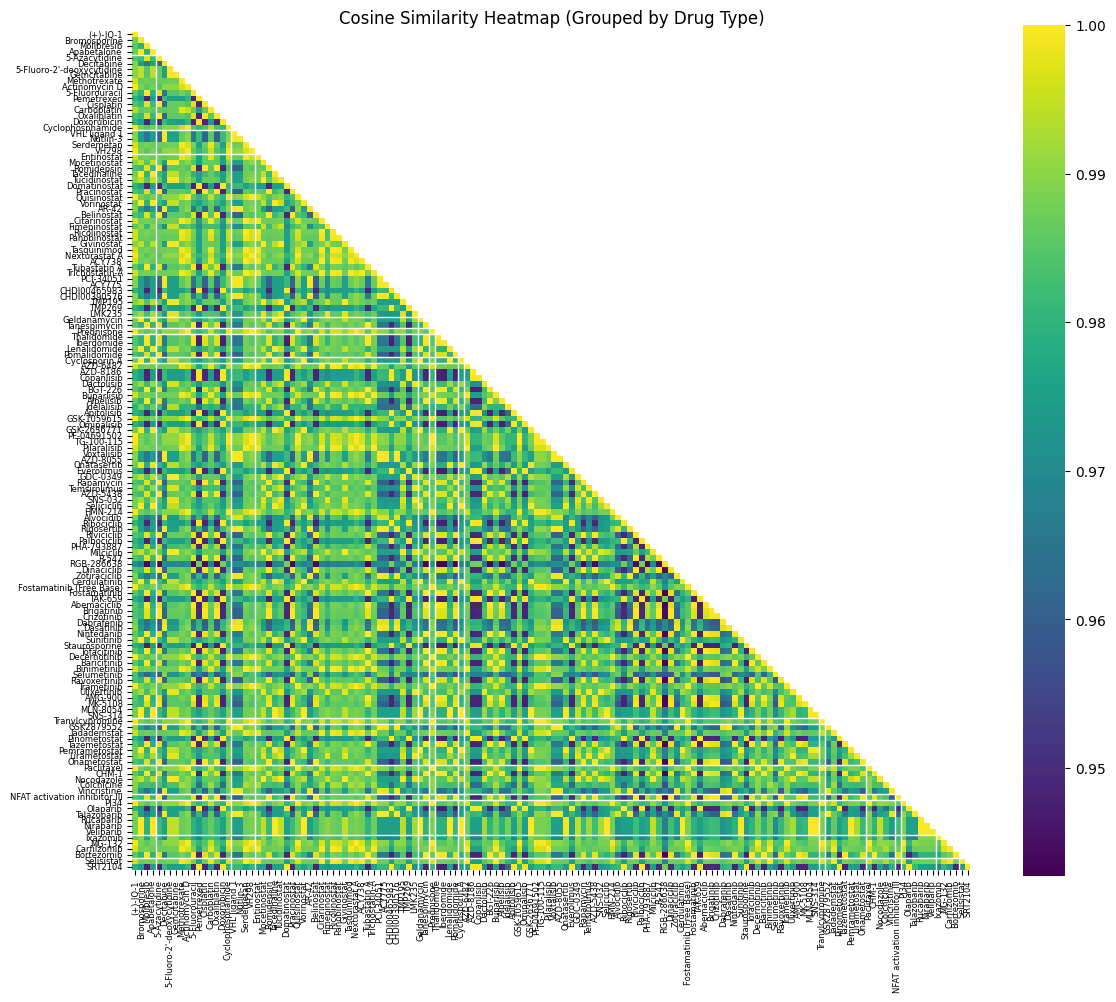

In [98]:
# plot cosine similarity heatmap 
upperMask = numpy.triu(numpy.ones_like(reorderedCosMatrix, dtype=bool), k=1)

# plot heatmap with boundary lines
plt.figure(figsize=(12, 10))
sns.heatmap(reorderedCosMatrix, cmap = "viridis", square=True, xticklabels=True, yticklabels=True, mask = upperMask)
plt.xticks(rotation=90, fontsize = 6)
plt.yticks(rotation=0, fontsize = 6)

# draw grid lines at group boundaries
for boundary in type_boundaries[:-1]:  # skip the last boundary (not needed)
    plt.axhline(boundary, color='white', linewidth=1)
    plt.axvline(boundary, color='white', linewidth=1)

plt.title("Cosine Similarity Heatmap (Grouped by Drug Type)")
plt.tight_layout()
plt.show()

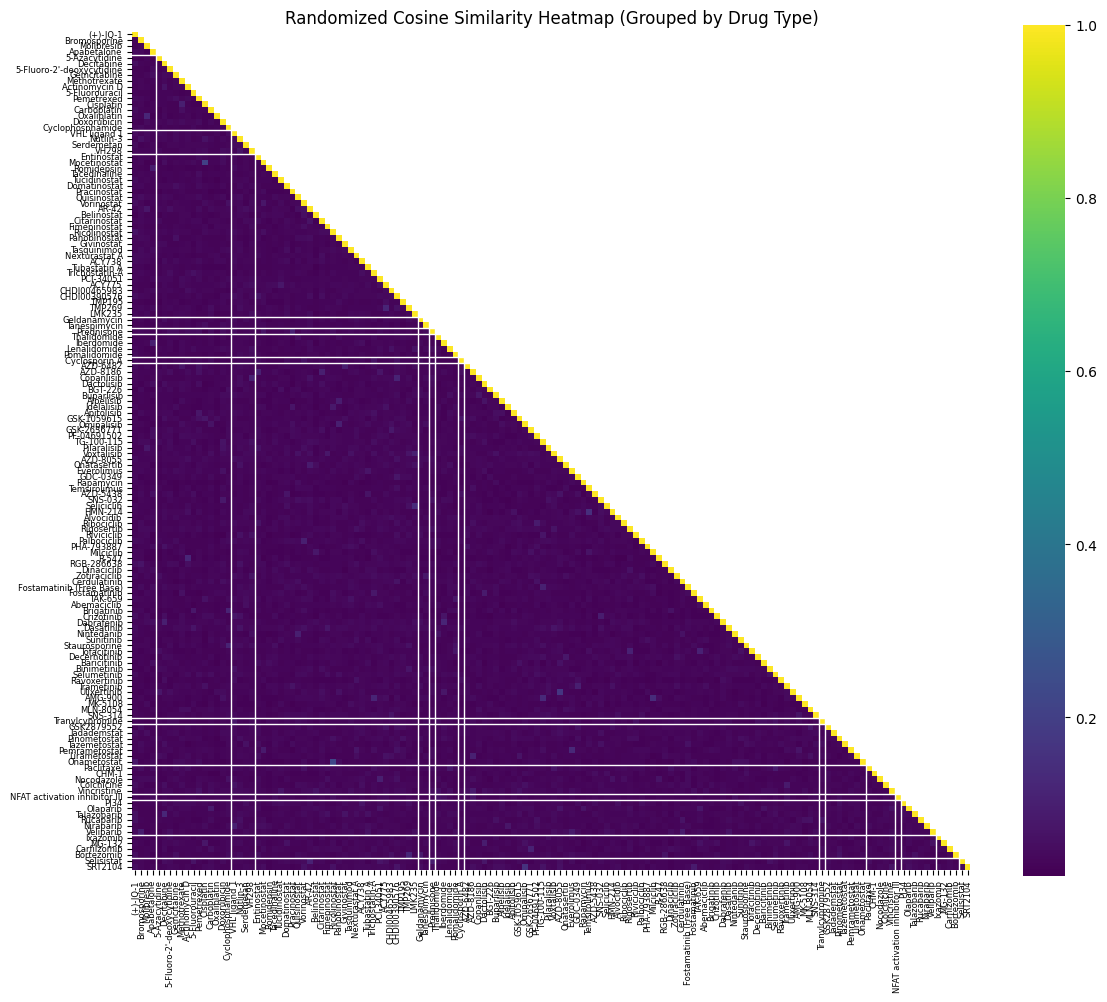

In [89]:
# plot randomized cosine similarity heatmap 
randUpperMask = numpy.triu(numpy.ones_like(reorderedRandomCosMatrix, dtype=bool), k=1)

# plot heatmap with boundary lines
plt.figure(figsize=(12, 10))
sns.heatmap(reorderedRandomCosMatrix, cmap='viridis', square=True, xticklabels=True, yticklabels=True, mask = randUpperMask)
plt.xticks(rotation=90, fontsize = 6)
plt.yticks(rotation=0, fontsize = 6)

# draw grid lines at group boundaries
for boundary in type_boundaries[:-1]:  # skip the last boundary (not needed)
    plt.axhline(boundary, color='white', linewidth=1)
    plt.axvline(boundary, color='white', linewidth=1)

plt.title("Randomized Cosine Similarity Heatmap (Grouped by Drug Type)")
plt.tight_layout()
plt.show()

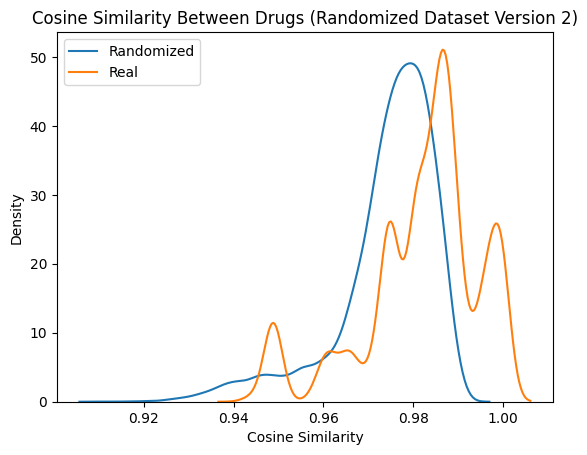

In [93]:
# randomizing drugs (??)
shuffledMatrix = meanIntensityMatrix.copy()
for gene in shuffledMatrix.index:
    shuffledMatrix.loc[gene] = np.random.permutation(shuffledMatrix.loc[gene])


# transpose data so drugs are rows, genes are columns
randomTransposedMatrix2 = shuffledMatrix.transpose()

# save drug names index column for after
drugNames = transposedData.index

# make new (randomized) cosine similarity matrix from the shuffled data
randomCosineSimilarityMatrix2 = cosine_similarity(randomTransposedMatrix2)
# convert to a dataframe and make row and column labels the drug names
randomCosineSimilarityMatrix2 = pd.DataFrame(randomCosineSimilarityMatrix2, columns = drugNames, index = drugNames)
# create randomized csv
randomCosineSimilarityMatrix2.to_csv("Cosine_Similarity_Matrix.csv")
# reorder similarity matrix according to drug type
reorderedRandomCosMatrix2 = randomCosineSimilarityMatrix2.loc[orderedDrugsList, orderedDrugsList]

# plot the real and randomized distributions together and compare
randomCosineArray2 = reorderedRandomCosMatrix2.to_numpy()
# get the indices of the lower triangle in the array
randomBottomDiagIndices2 = np.tril_indices_from(randomCosineArray2, k = -1)
# use indices to get values of the lower triangle in the array
randomBottomDiagVals2 = randomCosineArray2[randomBottomDiagIndices2]

# plot the distribution
sns.kdeplot(randomBottomDiagVals2, label = "Randomized")
sns.kdeplot(bottomDiagVals, label = "Real")
plt.xlabel("Cosine Similarity")
plt.title("Cosine Similarity Between Drugs (Randomized Dataset Version 2)")
plt.legend()
plt.show()

# maybe compute/compare  other statistics like mean or median similarity values (?)

